# Instructions 

1. Install tensorflow - "pip install tensorflow". Ensure the latest version of tensorflow is installed.   
- Install Keras - "pip install keras". Ensure keras v2.1.3 is installed. 
- Install scipy, numpy and scikit-learn libraries via pip. 


In [1]:
# necessary libraries 
import pickle
import numpy as np
% matplotlib inline
import matplotlib.pyplot as plt
import random
import time
import itertools

In [2]:
# file load helpers 
_totalBatch = 5
_IMAGE_NORMALISED = False

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def loadTrainigBatch(filepath):
    rawRGBFeatures = None
    trainingLabels = None
    
    for i in range(_totalBatch):
        # load all 5 batches and join the raw RGB data and indexes by row (vstack/hstack)? 
        #print(i+1)
        #print(batch1.keys())
        #print(labelMeta.keys())
        batch = unpickle(filepath + str(i + 1)) # load batch
        if i == 0: 
            rawRGBFeatures = batch.get(b"data")
            trainingLabels = batch.get(b"labels")
        else:
            rawRGBFeatures = np.vstack((rawRGBFeatures,batch.get(b"data")))
            trainingLabels = np.hstack((trainingLabels,batch.get(b"labels")))
    
    return rawRGBFeatures, trainingLabels

def loadHeldOutBatch(filepath):
    rawRGBFeatures = None
    labels = None
    
    batch = unpickle(filepath) # load batch
    rawRGBFeatures = batch.get(b"data")
    labels = np.asarray(batch.get(b'labels'))
    
    return rawRGBFeatures, labels

# image display helpers 
def printRandom10Images(rawData, labels, seed):    
    allImages = np.rot90(np.reshape(rawData, (rawData.shape[0],32,32,3), order='F'), axes=(2,1))
    print("raw image dimensions:", allImages.shape)
    # plot the first 10 random images to verify the conversion
    fig = plt.figure(figsize=(6,3))
    counter = 0
    random.seed(seed)
    for i in random.sample(range(1, rawData.shape[0]), 10):
        ax = fig.add_subplot(2, 5, 1 + counter, xticks=[], yticks=[])
        im = allImages[i,:,:,:] 
        ax.set_title(text_labels[labels[i]])
        plt.imshow(im)
        counter += 1
    plt.show()
    


In [3]:
# file loads - raw data + numerical labels + text labels

rawRGBFeatures, trainingLabels = loadTrainigBatch("data/cifar-10-batches-py/data_batch_")
labelMeta = unpickle("data/cifar-10-batches-py/batches.meta") # load the label metadata
text_labels = [x.decode("utf-8") for x in labelMeta.get(b"label_names")] # to convert from byte literal to string

print(rawRGBFeatures.shape)
print(trainingLabels.shape)

# extraction unique labels 
labels = np.unique(trainingLabels)
print(labels)
print(text_labels)

(50000, 3072)
(50000,)
[0 1 2 3 4 5 6 7 8 9]
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [4]:
# load the held out dataset 
holdOutRawFeatures, holdOutLabels = loadHeldOutBatch("data/cifar-10-batches-py/test_batch")
print(holdOutRawFeatures.shape)
print(holdOutLabels.shape)

(10000, 3072)
(10000,)


raw image dimensions: (50000, 32, 32, 3)


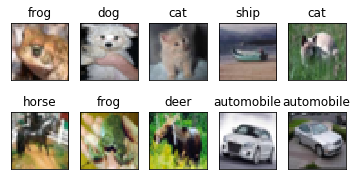

In [5]:
# print random 10 images
printRandom10Images(rawRGBFeatures,trainingLabels, seed=5)

## normalise the images (RGB) 

At times, you want to get rid of distortions caused by lights and shadows in an image. Normalizing the RGB values of an image can at times be a simple and effective way of achieving this.

When normalizing the RGB values of an image, you divide each pixel's value by the sum of the pixel's value over all channels. So if you have a pixel with intensitied R, G, and B in the respective channels... its normalized values will be R/S, G/S and B/S (where, S=R+G+B).

normalising
Images from the training set
raw image dimensions: (50000, 32, 32, 3)


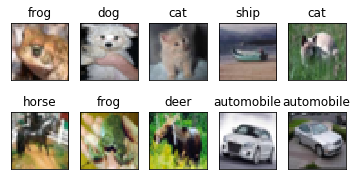

Images from the held out set
raw image dimensions: (10000, 32, 32, 3)


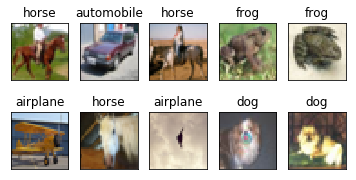

In [6]:
# normalise 
rawRGBFeatures = rawRGBFeatures.astype("float32") # convert the dataset to float32
holdOutRawFeatures = holdOutRawFeatures.astype("float32") 
if not _IMAGE_NORMALISED: 
    print("normalising")
    rawRGBFeatures = rawRGBFeatures/255 # normalise by dividing by 255
    holdOutRawFeatures = holdOutRawFeatures/255
    _IMAGE_NORMALISED = True
# now plot again to see verify the image quality 
print("Images from the training set")
printRandom10Images(rawRGBFeatures, trainingLabels, seed=5)
print("Images from the held out set")
printRandom10Images(holdOutRawFeatures, holdOutLabels, seed=5)


In [7]:
# split the data into train and test splits (80/20)

from sklearn.model_selection import train_test_split

train_data, eval_data, train_labels, eval_labels = train_test_split(rawRGBFeatures, trainingLabels, test_size=0.20, random_state=42)

train_data = train_data.astype("float32")
train_labels = train_labels.astype("float32")
eval_data = eval_data.astype("float32")
eval_labels = eval_labels.astype("float32")

print(train_data.shape)
print(train_labels.shape)
print(eval_data.shape)
print(eval_labels.shape)


(40000, 3072)
(40000,)
(10000, 3072)
(10000,)


## CNN - Tensorflow only

Let's build a model to classify the images in the cifar10 dataset using the following CNN architecture:

1. Convolutional Layer #1: Applies 32 5x5 filters (extracting 5x5-pixel subregions), with ReLU activation function
- Pooling Layer #1: Performs max pooling with a 2x2 filter and stride of 2 (which specifies that pooled regions do not overlap)
- Convolutional Layer #2: Applies 64 5x5 filters, with ReLU activation function
- Pooling Layer #2: Again, performs max pooling with a 2x2 filter and stride of 2
- Dense Layer #1: 1,024 neurons, with dropout regularization rate of 0.4 (probability of 0.4 that any given element will be dropped during training)
- Dense Layer #2 (Logits Layer): 10 neurons, one for each digit target class (0–9).

In [119]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Imports
import numpy as np
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.INFO)

# Our application logic will be added here

def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    # Input Layer
    # Reshape X to 4-D tensor: [batch_size, width, height, channels]
    # cifar10 images are 32x32 pixels, and have 3 color channels (RGB)
    input_layer = tf.reshape(features["x"], [-1,32,32,3])
    print("shape of initial input:", input_layer.shape)

    # Convolutional Layer #1
    # Computes 32 features using a 7x7 filter with ReLU activation.
    # Padding is added to preserve width and height.
    # Input Tensor Shape: [batch_size, 32, 32, 3]
    # Output Tensor Shape: [batch_size, 32, 32, 32]
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[7, 7],
        padding="same",
        activation=tf.nn.relu)
    
    print("shape post convolution:", conv1.shape)

    # Pooling Layer #1
    # First max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 32, 32, 32]
    # Output Tensor Shape: [batch_size, 16, 16, 32]
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    print("shape post conv1 pooling:", pool1.shape)

    # Convolutional Layer #2
    # Computes 64 features using a 7x7 filter.
    # Padding is added to preserve width and height.
    # Input Tensor Shape: [batch_size, 16, 16, 32]
    # Output Tensor Shape: [batch_size, 16, 16, 64]
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=64,
        kernel_size=[7, 7],
        padding="same",
        activation=tf.nn.relu)
    print("shape post conv 2:", conv2.shape)
    
    # Pooling Layer #2
    # Second max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 16, 16, 64]
    # Output Tensor Shape: [batch_size, 8, 8, 64]
    
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    print("shape post pool 2:", pool2.shape)

    # Flatten tensor into a batch of vectors
    # Input Tensor Shape: [batch_size, 8, 8, 64]
    # Output Tensor Shape: [batch_size, 8 * 8 * 64]
    pool2_flat = tf.reshape(pool2, [-1, 8 * 8 * 64])
    
    print("shape of flattened tensor prior to a fully connected layer:", pool2_flat.shape)

    # Dense Layer
    # Densely connected layer with 1024 neurons
    # Input Tensor Shape: [batch_size, 7 * 7 * 64]
    # Output Tensor Shape: [batch_size, 1024]
    dense = tf.layers.dense(inputs=pool2_flat, units=100, activation=tf.nn.relu)

    # Add dropout operation; 0.6 probability that element will be kept
    dropout = tf.layers.dropout(inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits layer
    # Input Tensor Shape: [batch_size, 1024]
    # Output Tensor Shape: [batch_size, 10]
    logits = tf.layers.dense(inputs=dropout, units=10)

    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=10)
    loss = tf.losses.softmax_cross_entropy(onehot_labels=onehot_labels, logits=logits)
    tf.summary.scalar('Cross Entropy', loss)
    
    merged = tf.summary.merge_all()
    
    #loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(loss=loss,global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}

    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)



### Train and eval the CNN model 


(40000, 3072)
(40000,)
(10000, 3072)
(10000,)


In [120]:
# Create the Estimator
cifar10_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir="tmp/cifar10_convnet_model")

# Set up logging for predictions
# Log the values in the "Softmax" tensor with label "probabilities"
#tensors_to_log = {"probabilities": "softmax_tensor"}
#logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)

# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": train_data},
      y=train_labels,
      batch_size=100,
      num_epochs=None,
      shuffle=True)
#cifar10_classifier.train(input_fn=train_input_fn,steps=20000,hooks=[logging_hook])
cifar10_classifier.train(input_fn=train_input_fn,steps=20)



INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}
shape of initial input: (100, 32, 32, 3)
shape post convolution: (100, 32, 32, 32)
shape post conv1 pooling: (100, 16, 16, 32)
shape post conv 2: (100, 16, 16, 64)
shape post pool 2: (100, 8, 8, 64)
shape of flattened tensor prior to a fully connected layer: (100, 4096)
INFO:tensorflow:Summary name Cross Entropy is illegal; using Cross_Entropy instead.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from tmp/cifar10_convnet_model/model.ckpt-5040
INFO:tensorflow:Saving checkpoints for 5041 into tmp/cifar10_convnet_model/model.ckpt.
INFO:tensorflow:loss = 1.73501, step = 5041
INFO:tensorflow:Saving checkpoints for 5060 into tmp/cifar10_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 1.69209.


In [106]:
# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)
eval_results = cifar10_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

shape of initial input: (?, 32, 32, 3)
shape post convolution: (?, 32, 32, 32)
shape post conv1 pooling: (?, 16, 16, 32)
shape post conv 2: (?, 16, 16, 64)
shape post pool 2: (?, 8, 8, 64)
shape of flattened tensor prior to a fully connected layer: (?, 4096)
INFO:tensorflow:Starting evaluation at 2018-05-19-13:15:25
INFO:tensorflow:Restoring parameters from tmp/cifar10_convnet_model/model.ckpt-5000
INFO:tensorflow:Finished evaluation at 2018-05-19-13:15:42
INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.3935, global_step = 5000, loss = 1.70058
{'accuracy': 0.3935, 'loss': 1.7005845, 'global_step': 5000}


In [116]:
print(losses[0])

Tensor("softmax_cross_entropy_loss/value:0", shape=(), dtype=float32)


## CNN - Using Keras

In [8]:
from __future__ import print_function

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report

import keras
import tensorflow as tf
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.utils import np_utils
import os

np.random.seed(2018)
if K.backend()=='tensorflow':
    print(K.image_dim_ordering())
    
# TRAINING CONSTANTS
batch_size = 32
num_classes = 10
epochs = 100
data_augmentation = True
    
_KERAS_BASE_PATH = os.path.join(os.getcwd(), "files/keras/")
_MODEL_NAME = "cifar_v1"
_KERAS_CHECKPOINT_PATH = _KERAS_BASE_PATH + "checkpoints/"
_KERAS_CHECKPOINT_FORMAT = "weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
_KERAS_TENSORBOARD_LOG_DIR = _KERAS_BASE_PATH + "tensorboardLogs/"

# create the required directories for saving checkpoints
if not os.path.isdir(_KERAS_BASE_PATH):
    os.makedirs(_KERAS_BASE_PATH)
if not os.path.isdir(_KERAS_CHECKPOINT_PATH):
    os.makedirs(_KERAS_CHECKPOINT_PATH)
if not os.path.isdir(_KERAS_TENSORBOARD_LOG_DIR):
    os.makedirs(_KERAS_TENSORBOARD_LOG_DIR)

 

Using TensorFlow backend.


tf


In [9]:
# helpers 

def plotAxis(model_history, axs, perfName, yLabel):
    # summarize history for Precision
    axs[0].plot(range(1,len(model_history.history[perfName])+1),model_history.history[perfName])
    axs[0].plot(range(1,len(model_history.history['val_' + perfName])+1),model_history.history['val_' + perfName])
    axs[0].set_xticks(np.arange(1,len(model_history.history[perfName])+1),len(model_history.history[perfName])/10)

def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    plotAxis(model_history, axs, "acc","Accuracy")
    # summarize history for F1
    plotAxis(model_history, axs, "F1","F-Measure")
    # summarize history for Precision
    #plotAxis(model_history, axs, "Precision","Precision")
    # summarize history for Recall
    #plotAxis(model_history, axs, "Recall","Recall")
    
    axs[0].set_title('Model Performance Metrics over the epochs')
    axs[0].set_ylabel('Performance Measures')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train acc', 'val acc', 'train F1', 'val F1' ], loc='best')
    
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    
    plt.show()
    
def drawROCCurves(y_true, y_pred): 
    y_true = label_binarize(y_true, classes=labels)
    y_pred = label_binarize(y_pred, classes=labels)
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i]) 
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    plt.figure(figsize=(10,7))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
        
    # plot all the class ROCs
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2,label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(text_labels[i], roc_auc[i]))
        
    # Plot micro-avg ROC curve
    
    plt.plot(fpr["micro"], tpr["micro"],label='micro-average ROC curve (area = {0:0.2f})'
             ''.format(roc_auc["micro"]),color='deeppink', linestyle=':', linewidth=6)
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC of CNN')
    plt.legend(loc="lower right")
    
def plot_confusion_matrix(cm,
                          title='Cifar10 Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.figure(figsize=(10,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(text_labels))
    plt.xticks(tick_marks, text_labels, rotation=45)
    plt.yticks(tick_marks, text_labels)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def CNN_Predict(test_x, model):
    result = model.predict(test_x)
    y_pred = np.argmax(result, axis=1)
    return y_pred

def EvaluateModel(y_test, y_pred): 
    
    # over all accuracy 
    accuracy = (np.sum(y_pred == y_test)/y_test.shape[0])*100
    print("Accuracy of model is: %0.2f"%accuracy)
    
    # confusion matrix 
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, "Confusion Matrix")
    # print out the classification report 
    print(classification_report(y_test, y_pred, target_names=text_labels))
    # draw the ROC Curve
    drawROCCurves(y_test, y_pred)

# keras custom metrics 
def Precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def Recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def F1(y_true, y_pred):
    p = Precision(y_true, y_pred)
    r = Recall(y_true, y_pred)
    f1 = 2*(r * p) / (r + p)
    return f1


### Design & Training CNN model 

| Layer name | Description |
| :--- |:------------- |
| Convolution 1      | 32 features with 3x3 kernel with ReLU activation |
| Convolution 2      | 32 features with 3x3 kernel with ReLU activation |
| Max pooling 1 | max pooling with 2x2 pool size and a dropout of 0.25 to counter overfitting issues |
| Convolution 3 | 64 features with 3x3 kernel with ReLU activation |
| Convolution 4 | 64 features with 3x3 kernel with ReLU activation |
| Max pooling 2 | max pooling with 2x2 pool size and a dropout of 0.25 to counter overfitting issues |
| dense layer 1 | 512 neurons/units with ReLU activation followed by a dropout at 0.5 |
| Dense layer 2 (softmax) | 10 neurons/units (10 classes) with softmax activation to produce logits (final prediction) |


In [10]:
# prep the dataset for training and testing 
xTrain = np.rot90(np.reshape(train_data, (40000,32,32,3), order='F'), axes=(2,1))
xTest = np.rot90(np.reshape(eval_data, (10000,32,32,3), order='F'), axes=(2,1))
# convert the labels to one hot encoded values
y_train = keras.utils.to_categorical(train_labels, num_classes)
y_test = keras.utils.to_categorical(eval_labels, num_classes)


In [11]:
# CNN layers 

model = Sequential()
# layer 1 - conv 1: 32 features with 3x3 kernel with ReLU activation
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=xTrain.shape[1:])) # channel last data type by default
model.add(Activation('relu'))
# layer 2 - conv 2: 32 features with 3x3 kernel with ReLU activation
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))

# layer 3 - pool 1: max pooling with 2x2 pool size and a dropout to deal with some overfitting issues
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# layer 4 - conv 3: 64 features with 3x3 kernel with ReLU activation
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
# layer 5 - conv 4: 64 features with 3x3 kernel with ReLU activation
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))

# layer 6 - pool 2: max pooling with 2x2 pool size and a dropout to deal with some overfitting issues
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# layer 7 - conv 5: 128 filters with 3x3 kernel with ReLU activation 
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
# layer 8 - conv 5: 128 filters with 3x3 kernel with ReLU activation 
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))

# layer 9 - pool 3: max pooling with 2x2 pool size and a dropout to deal with some overfitting issues
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

# layer 10 - Dense 1: 512 neurons/units with ReLU activation followed by a dropout at 0.5
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# layer 11 - Dense 2: 256 neurons/units with ReLU activation followed by a dropout at 0.5
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# layer 12 - Dense 2: 10 neurons/units (for 10 classes) with softmax activation for final prediction
model.add(Dense(num_classes))
model.add(Activation('softmax'))


In [75]:
# checkpoint
checkpoint = ModelCheckpoint(_KERAS_CHECKPOINT_PATH + _KERAS_CHECKPOINT_FORMAT, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#tensorboard = TensorBoard(log_dir=_KERAS_TENSORBOARD_LOG_DIR, histogram_freq=1, batch_size=32, 
#                            write_graph=True, write_grads=True, 
#                            write_images=False, embeddings_freq=0, 
#                            embeddings_layer_names=None, embeddings_metadata=None)

callbacks_list = [checkpoint]

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision, Recall, F1])

# Train the model
start = time.time()
model_info = model.fit(xTrain, y_train, 
                       batch_size=100, epochs=50, 
                       validation_data = (xTest, y_test),
                       callbacks = callbacks_list,
                       verbose=2)
print("Model took %0.2f seconds to train"%(time.time() - start))

Train on 40000 samples, validate on 10000 samples
Epoch 1/50

Epoch 00001: val_acc improved from -inf to 0.72690, saving model to /Users/nagibshah/dev/CIFAR-10-ImageClassifier/files/keras/checkpoints/weights-improvement-01-0.73.hdf5
 - 219s - loss: 0.9163 - acc: 0.6808 - Precision: 0.8055 - Recall: 0.5630 - F1: 0.6619 - val_loss: 0.7797 - val_acc: 0.7269 - val_Precision: 0.8398 - val_Recall: 0.6054 - val_F1: 0.7028
Epoch 2/50

Epoch 00002: val_acc improved from 0.72690 to 0.72700, saving model to /Users/nagibshah/dev/CIFAR-10-ImageClassifier/files/keras/checkpoints/weights-improvement-02-0.73.hdf5
 - 217s - loss: 0.8466 - acc: 0.7043 - Precision: 0.8137 - Recall: 0.5959 - F1: 0.6872 - val_loss: 0.7592 - val_acc: 0.7270 - val_Precision: 0.8243 - val_Recall: 0.6370 - val_F1: 0.7181
Epoch 3/50

Epoch 00003: val_acc improved from 0.72700 to 0.73660, saving model to /Users/nagibshah/dev/CIFAR-10-ImageClassifier/files/keras/checkpoints/weights-improvement-03-0.74.hdf5
 - 215s - loss: 0.8117 

Epoch 28/50

Epoch 00028: val_acc did not improve
 - 198s - loss: 0.4832 - acc: 0.8362 - Precision: 0.8873 - Recall: 0.7890 - F1: 0.8350 - val_loss: 0.6313 - val_acc: 0.7924 - val_Precision: 0.8499 - val_Recall: 0.7418 - val_F1: 0.7920
Epoch 29/50

Epoch 00029: val_acc did not improve
 - 207s - loss: 0.4811 - acc: 0.8379 - Precision: 0.8854 - Recall: 0.7902 - F1: 0.8348 - val_loss: 0.6107 - val_acc: 0.7999 - val_Precision: 0.8643 - val_Recall: 0.7380 - val_F1: 0.7959
Epoch 30/50

Epoch 00030: val_acc did not improve
 - 206s - loss: 0.4659 - acc: 0.8414 - Precision: 0.8894 - Recall: 0.7971 - F1: 0.8405 - val_loss: 0.6098 - val_acc: 0.8012 - val_Precision: 0.8521 - val_Recall: 0.7548 - val_F1: 0.8003
Epoch 31/50

Epoch 00031: val_acc did not improve
 - 208s - loss: 0.4630 - acc: 0.8431 - Precision: 0.8896 - Recall: 0.7986 - F1: 0.8414 - val_loss: 0.6264 - val_acc: 0.7981 - val_Precision: 0.8542 - val_Recall: 0.7528 - val_F1: 0.8001
Epoch 32/50

Epoch 00032: val_acc did not improve
 - 215

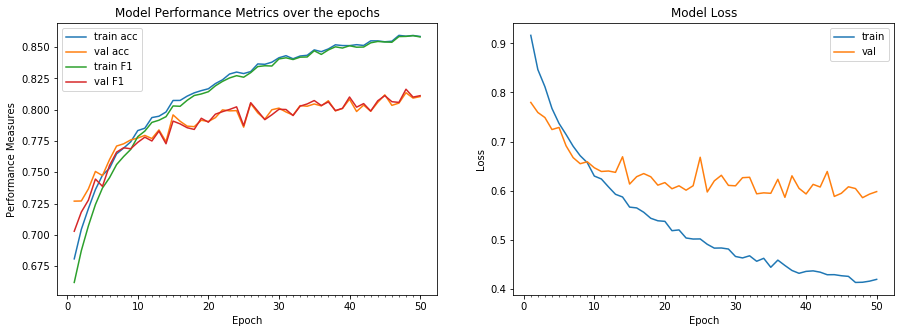

Model took 14.91 seconds to predict test set


In [112]:
# plot model history
plot_model_history(model_info)
# prep the held out dataset 
xHeldOut = np.rot90(np.reshape(holdOutRawFeatures, (10000,32,32,3), order='F'), axes=(2,1))
# compute accuracy on held out dataset
start = time.time()
y_predicted = CNN_Predict(model=model,test_x=xHeldOut)
print("Model took %0.2f seconds to predict test set"%(time.time() - start))

Accuracy of model is: 79.99
             precision    recall  f1-score   support

   airplane       0.80      0.84      0.82      1000
 automobile       0.91      0.92      0.91      1000
       bird       0.71      0.71      0.71      1000
        cat       0.68      0.56      0.61      1000
       deer       0.76      0.79      0.77      1000
        dog       0.82      0.65      0.72      1000
       frog       0.74      0.90      0.82      1000
      horse       0.83      0.85      0.84      1000
       ship       0.86      0.90      0.88      1000
      truck       0.88      0.88      0.88      1000

avg / total       0.80      0.80      0.80     10000



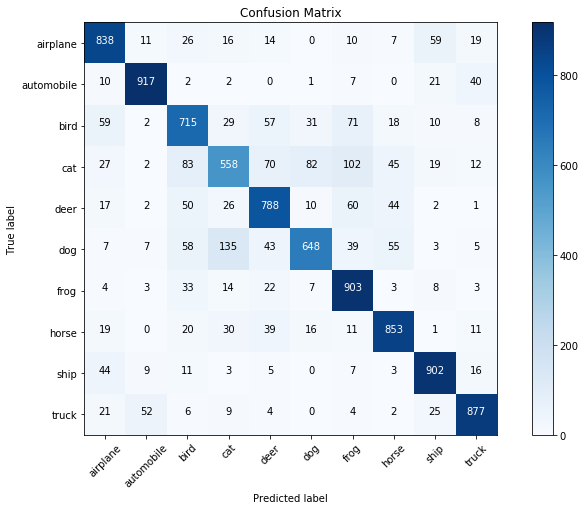

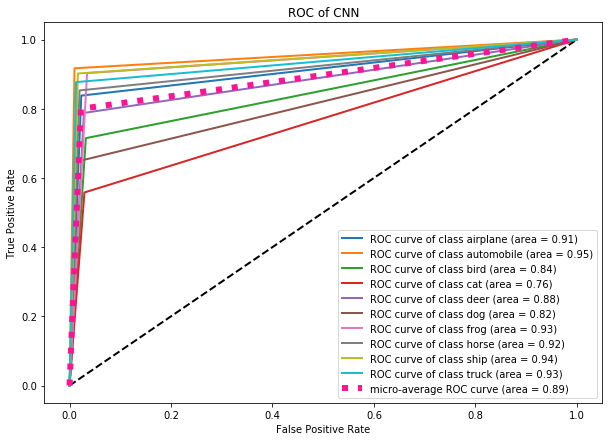

In [158]:
# evaluate the model 
EvaluateModel(y_pred=y_predicted, y_test=holdOutLabels)

In [176]:
# save the keras model (in HDF format)
_MODEL_NAME = "cifar10_v2"
model.save(_KERAS_BASE_PATH + _MODEL_NAME + ".h5")

with open(_KERAS_BASE_PATH + "/cifar10_v2_model_summary", 'wb') as fo:
    modelSummary = model_info.history
    pickle.dump(modelSummary, fo)

# returns a compiled model
# identical to the previous one
#from keras.models import load_model
#model2 = load_model('files/keras/cifar_v1.h5')
# Train the model
#start = time.time()
#print("Accuracy on test data is: %0.2f"%accuracy(xTest, y_test, model2))
#print("Model took %0.2f seconds to predict test set"%(time.time() - start))

In [165]:
print(labels)

[0 1 2 3 4 5 6 7 8 9]
<bound method Container.summary of <keras.models.Sequential object at 0x11c346be0>>


## BOVW - SVM

In [12]:
# helpers for image feature extraction and processing
from skimage.filters import roberts, sobel, scharr, prewitt
from skimage.color import rgb2gray
from skimage.exposure import equalize_hist
from skimage.filters import threshold_otsu

def show_images(images,titles=None):
    """Display a list of images"""
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure(figsize=(1.5,1.5))
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n) # Make subplot
        if image.ndim == 2: # Is image grayscale?
            plt.gray() # Only place in this blog you can't replace 'gray' with 'grey'
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()
    
def ConvertToGray(RGBArray):
    grayImages = np.empty((RGBArray.shape[0],32,32))
    #edgeSobelImages = np.empty((RGBArray.shape[0],32,32))
    #binaryImages = np.empty((RGBArray.shape[0],32,32))
    #histEqualisedImages = np.empty((RGBArray.shape[0],32,32))
    for i in range(RGBArray.shape[0]):
        # convert
        gray_image = rgb2gray(RGBArray[i,:,:,:])
        #edge_sobel = sobel(gray_image)
        #equalized_image = equalize_hist(gray_image)
        #thresh = threshold_otsu(gray_image)
        #binary_image = gray_image > thresh
        
        grayImages[i] = gray_image[np.newaxis,:,:]
        #edgeSobelImages[i] = edge_sobel[np.newaxis,:,:]
        #binaryImages[i] = binary_image[np.newaxis,:,:]
        #histEqualisedImages[i] = equalized_image[np.newaxis,:,:]
    return grayImages #, edgeSobelImages, binaryImages, histEqualisedImages

In [13]:
# prep the dataset for training and testing 
xTrain = np.rot90(np.reshape(rawRGBFeatures, (50000,32,32,3), order='F'), axes=(2,1))
yTrain = trainingLabels

# convert the images to grayscale 
start = time.time()
grayImages = ConvertToGray(xTrain)
print("Procesing took %0.2f seconds"%(time.time() - start))


Procesing took 2.19 seconds


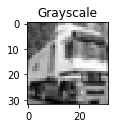

In [14]:
# visualise the transformation

gray_image = grayImages[1,:,:]
#equalized_image = equalize_hist(gray_image)
#thresh = threshold_otsu(gray_image)

show_images(images=[gray_image],
           titles=["Grayscale"])

In [15]:
# generate some SIFT features 

from skimage import data
from skimage import transform as tf
from skimage.feature import daisy

#grayImages2d = grayImages.reshape((grayImages.shape[0], 1024)) # convert to 2d array if images

#img1 = grayImages[1,:,:]
#img2 = grayImages[2,:,:]

def extractDaisyFeatures(grayImages):
    bov_descriptors = np.empty((grayImages.shape[0],36,104))

    for i in range(grayImages.shape[0]):
        img = grayImages[i,:,:]
        descs = daisy(img, step=5, radius=3, rings=2, histograms=6, orientations=8, visualize=False)
        descsTransformed = descs.reshape((-1 ,descs.shape[2])) # flatten the features dimensions
        #print(descs.shape)
        #print(descsTransformed.shape)
        bov_descriptors[i] = descsTransformed

    # reshape to flatten the features dimensions
    formattedBOVs = bov_descriptors.reshape((-1, bov_descriptors.shape[2]))
    
    return formattedBOVs, bov_descriptors

start = time.time()
bov_descriptors, descriptor_list = extractDaisyFeatures(grayImages)
print("Procesing took %0.2f seconds"%(time.time() - start))

print(bov_descriptors.shape)


Procesing took 93.63 seconds
(1800000, 104)


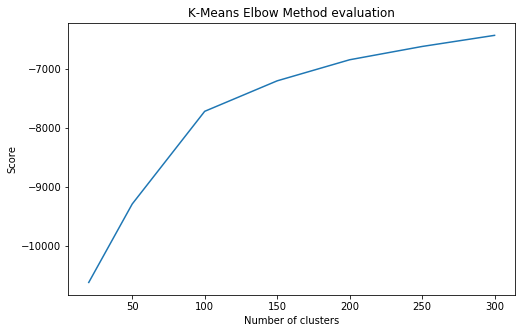

In [25]:
# carry out a k-means clustering 
from sklearn.cluster import MiniBatchKMeans

#start = time.time()
#range_n_clusters = [20,50,100,150,200,250,300]
#km = [MiniBatchKMeans(n_clusters=i) for i in range_n_clusters]
#score = [km[i].fit(bov_descriptors).score(bov_descriptors) for i in range(len(range_n_clusters))]
#print("Clustering range search took %0.2f seconds"%(time.time() - start))

plt.figure(figsize=(8,5))
plt.title("K-Means Elbow Method evaluation")
plt.plot(range_n_clusters, score)
plt.ylabel('Score')
plt.xlabel('Number of clusters')


# create clusters
#    start = time.time()
#    clusters = MiniBatchKMeans(n_clusters=n).fit_predict(bov_descriptors)
#    print("Clustering took %0.2f seconds"%(time.time() - start))



#import sys 
#print(sys.getsizeof(bov_descriptors)/1024/1024)
#print(descriptor_list.shape)



In [23]:
# create bag of visual words 
from sklearn.preprocessing import StandardScaler

def GenerateCodebook(n_images, descriptor_list, kcluster):
    mega_histogram = np.array([np.zeros(50) for i in range(n_images)])
    old_count = 0
    for i in range(n_images):
        l = len(descriptor_list[i])
        for j in range(l):
            idx = kcluster[old_count+j]
            mega_histogram[i][idx] += 1
        old_count += l
    
    scale = StandardScaler().fit(mega_histogram)
    mega_histogram = scale.transform(mega_histogram)
    
    return mega_histogram

start = time.time()
codebook = GenerateCodebook(grayImages.shape[0], descriptor_list, clusters)
print("Time taken to generate codebook: %0.2f seconds"%(time.time() - start))


Time taken to generate codebook: 1.47 seconds


In [24]:
print(codebook.shape)

(50000, 50)


SVD training took 188.32 seconds


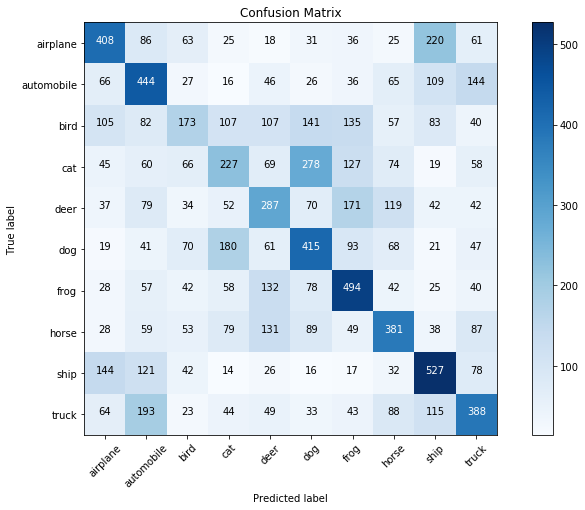

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

train_data, eval_data, train_labels, eval_labels = train_test_split(codebook, trainingLabels, 
                                                                    test_size=0.20, random_state=42)

clf = SVC(C=1.0)
start = time.time()
clf.fit(train_data, train_labels)
print("SVD training took %0.2f seconds"%(time.time() - start))
preds = clf.predict(eval_data)


In [1]:
# evaluatate the model
EvaluateModel(y_pred=preds, y_test=eval_labels)

NameError: name 'EvaluateModel' is not defined

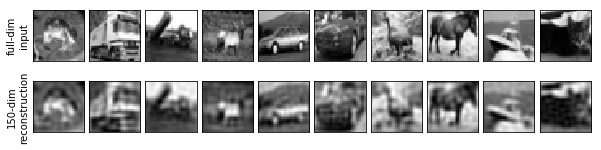

In [265]:
from sklearn import decomposition

pca = decomposition.PCA()
start = time.time()
# Plot the PCA spectrum
pca.fit(grayImages2d)
print("Procesing took %0.2f seconds"%(time.time() - start))



Procesing took 8.55 seconds


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

SVC = SVC()

#SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
#    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
#    max_iter=-1, probability=False, random_state=None, shrinking=True,
#    tol=0.001, verbose=False)

pipe = Pipeline(steps=[('pca', pca), ('SVC', SVM)])

# Prediction
n_components = [10,50,150,200,500]
Cs = [0.01, 0.1, 1, 1.5]
kernels = ["rbf"]

# Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(pipe,dict(pca__n_components=n_components,SVC__C=Cs))

start = time.time()
estimator.fit(grayImages2d, yTrain)
print("GridsearchCV took %0.2f seconds"%(time.time() - start))


In [1]:
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()

NameError: name 'plt' is not defined